# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [50]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, udf, isnan, count, when, desc, sort_array, asc, avg, lag, floor
from pyspark.sql.types import IntegerType, DateType
from pyspark.sql.window import Window
from pyspark.sql.functions import sum as Fsum
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.sql.types import DoubleType
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import datetime
from pyspark.ml import Pipeline 
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import pyspark.sql.functions as psqf
import seaborn as sns
import matplotlib.pyplot as plt

# Load and Clean Dataset

In this workspace, the mini-dataset file is mini_sparkify_event_data.json. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids.

In [51]:
# Create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Identify Features") \
    .getOrCreate()

df = spark.read.json('mini_sparkify_event_data.json')

In [52]:
df.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [53]:
# Print schema for future reference
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [54]:
print(df.take(1))

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]


In [55]:
total = float(df.count())
missing = float(df.filter(df.registration.isNull()).count())
percentage = missing *100.0 /total

#### Dropping Missing Items : -

In [56]:
print(df.count(), len(df.columns))
print("Missing Value in Columns :- ")
for colName, dtype in df.dtypes:
    print(colName,':', df.filter(df[colName].isNull()).count())

286500 18
Missing Value in Columns :- 
artist : 58392
auth : 0
firstName : 8346
gender : 8346
itemInSession : 0
lastName : 8346
length : 58392
level : 0
location : 8346
method : 0
page : 0
registration : 8346
sessionId : 0
song : 58392
status : 0
ts : 0
userAgent : 8346
userId : 0


#### We can see from above ther are missing items:

1. userID, itemInSession, sessionID, time stamp,authorization, level, method and page has zero missing values.

2. Artist, Length and Song have same number of missing values

3. User Agent, registration, first name, last name, location and gender have the same number of missing values.

In [57]:
df.filter(df.registration.isNull()).show(1,False)

print("Number of rows with missing registration: ", df.filter(df.registration.isNull()).count())
print("Number of rows with missing registration, name, gender, location and user agent: ",\
      df.filter(df.registration.isNull() & df.firstName.isNull() & df.lastName.isNull() &
               df.gender.isNull() & df.location.isNull() & df.userAgent.isNull()).count()) 

df = df.filter(df.registration.isNotNull())

+------+----------+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+-------------+---------+------+
|artist|auth      |firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status|ts           |userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+-------------+---------+------+
|null  |Logged Out|null     |null  |100          |null    |null  |free |null    |GET   |Home|null        |8        |null|200   |1538355745000|null     |      |
+------+----------+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+-------------+---------+------+
only showing top 1 row

Number of rows with missing registration:  8346
Number of rows with missing registration, name, gender, location and user agent:  8346


In [58]:
print ("Missing percentage:-",percentage)

Missing percentage:- 2.913089005235602


The above registration are missing (8346) at the same row, where the users are not logged in. So, We can't identify these users individually and they constitute just ~3% of the records we drop the rows where registration is 0.

Total Records : 286500

Missing Registration: 8346

Missing Registration : 2.91%

### Columns to Drop

1. First name and last name are not useful
2. Auth has no variability
3. Uniquely identify a user by user id, so registration number isn't needed
4. All activities of a user will be collected without factoring in timestamp

In [59]:
print("Number of rows with missing artist: ", df.filter(df.artist.isNull()).count())
print("Number of rows with missing artist, song, song length in same row: ",\
      df.filter(df.artist.isNull() & df.song.isNull() & df.length.isNull()).count()) 

print("Next song page with missing song: ", df.filter(df.song.isNull() & (df.page=="NextSong")).count()) 
print("Song on a different page: ", df.filter(df.song.isNotNull() & (df.page!="NextSong")).count())

Number of rows with missing artist:  50046
Number of rows with missing artist, song, song length in same row:  50046
Next song page with missing song:  0
Song on a different page:  0


In [60]:
print ("Missing Registration Percentage:-",float(df.filter(df.artist.isNull() & df.song.isNull() & df.length.isNull()).count()*100.0)/total)

Missing Registration Percentage:- 17.468062827225133


There are song which has missing values as length and artist we find,

When song is null, length is not defined as well as artist. Song is only present on the page nextSong.

Total Records : 286500

Missing Song (not a song page): 58392

Missing Registration : 17.47%

17.47% rows do not contain songs but these other pages can be relevant in determining churn so we will use it later, instead of dropping it.


In [61]:
df.groupby('level','page').count().sort('page').show(100,False)
df.groupby('page','method').count().sort('page','method').show(100,False)

+-----+-------------------------+------+
|level|page                     |count |
+-----+-------------------------+------+
|free |About                    |93    |
|paid |About                    |402   |
|free |Add Friend               |893   |
|paid |Add Friend               |3384  |
|paid |Add to Playlist          |5354  |
|free |Add to Playlist          |1172  |
|paid |Cancel                   |31    |
|free |Cancel                   |21    |
|free |Cancellation Confirmation|21    |
|paid |Cancellation Confirmation|31    |
|paid |Downgrade                |2055  |
|free |Error                    |53    |
|paid |Error                    |199   |
|paid |Help                     |1132  |
|free |Help                     |322   |
|paid |Home                     |7461  |
|free |Home                     |2621  |
|free |Logout                   |922   |
|paid |Logout                   |2304  |
|free |NextSong                 |41991 |
|paid |NextSong                 |186117|
|paid |Roll Adve

#### Looking into above table :

Free users can reach upgrade and submit upgrade page
Paid users can reach downgrade and submit downgrade page

The remaining pages are common. A page has either GET or PUT method not both.


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [62]:
# Observation
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [63]:
# Look at 2 rows for sample
df.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [64]:
df.select('level').distinct().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [65]:
level_counts= df.groupby('level').agg({'level':'count'}).withColumnRenamed("count(level)", "level_count")
level_counts.show()

+-----+-----------+
|level|level_count|
+-----+-----------+
| free|      55721|
| paid|     222433|
+-----+-----------+



In [66]:
page_counts= df.groupby('page').agg({'page':'count'}).withColumnRenamed("count(page)", "page_count")
page_counts.show()

+--------------------+----------+
|                page|page_count|
+--------------------+----------+
|              Cancel|        52|
|    Submit Downgrade|        63|
|         Thumbs Down|      2546|
|                Home|     10082|
|           Downgrade|      2055|
|         Roll Advert|      3933|
|              Logout|      3226|
|       Save Settings|       310|
|Cancellation Conf...|        52|
|               About|       495|
|            Settings|      1514|
|     Add to Playlist|      6526|
|          Add Friend|      4277|
|            NextSong|    228108|
|           Thumbs Up|     12551|
|                Help|      1454|
|             Upgrade|       499|
|               Error|       252|
|      Submit Upgrade|       159|
+--------------------+----------+



In [67]:
level_counts= df.groupby('level').agg({'level':'count'}).withColumnRenamed("count(level)", "level_count")
level_counts.show()

+-----+-----------+
|level|level_count|
+-----+-----------+
| free|      55721|
| paid|     222433|
+-----+-----------+



In [68]:
#Cancel and Cancellation Confirmation samples in the dataset
cancel_events = df.filter(psqf.col('page').isin(['Cancel','Cancellation Confirmation'])).select(['userID','page', 'firstName', 'lastName','ts', 'auth'])
cancel_events.show(5, False)

+------+-------------------------+---------+--------+-------------+---------+
|userID|page                     |firstName|lastName|ts           |auth     |
+------+-------------------------+---------+--------+-------------+---------+
|18    |Cancel                   |Adriel   |Mendoza |1538943740000|Logged In|
|18    |Cancellation Confirmation|Adriel   |Mendoza |1538943990000|Cancelled|
|32    |Cancel                   |Diego    |Mckee   |1539033031000|Logged In|
|32    |Cancellation Confirmation|Diego    |Mckee   |1539033046000|Cancelled|
|125   |Cancel                   |Mason    |Hart    |1539318918000|Logged In|
+------+-------------------------+---------+--------+-------------+---------+
only showing top 5 rows



In [69]:
churn_event = df.groupby('userId').agg(psqf.collect_list('page').alias('pages'))
# define 1 as churned, 0 otherwise
churn_f = psqf.udf(lambda x: 1 if 'Cancel' in set(x) else 0)
churn_event = churn_event.withColumn("label", churn_f(churn_event.pages)).drop('pages')

In [70]:
labeled_df  = churn_event.join(df, 'userId')
labeled_df.show()

+------+-----+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+
|userId|label|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|       page| registration|sessionId|                song|status|           ts|           userAgent|
+------+-----+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+
|100010|    0|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT|   NextSong|1538016340000|       31|Captain Tyin Knot...|   200|1539003534000|"Mozilla/5.0 (iPh...|
|100010|    0|Francesca Battist...|Logged In| Darianna|     F|            1|Carp

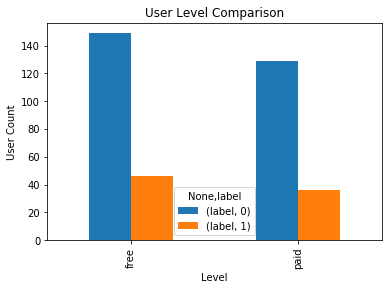

In [71]:
use_level_count = labeled_df.groupby('userId', 'Level', 'label').count()
use_level_count_pd  = use_level_count.select("userId", "Level", 'label').toPandas()
use_level_count_pd[['Level', 'label']].groupby(['Level', 'label']).agg({'label':'count'}).unstack().plot(kind='bar');
plt.title('User Level Comparison')
plt.ylabel('User Count');

#### In above figure shows the comparison with free user vs paid user
a. Paid users listen songs which length is longer than free users.

b. Paid users are less although they are more likely to churn than free users.

c. Users those leave the app who have lesser Thumbs Up to Thumbs Down ratio than those who are continuously using.

Note: churned - 1 & active - 0

In [72]:
# Get number of users
df.select("userId").dropDuplicates().count()

225

In [73]:
# Get number of sessions
df.select("sessionId").dropDuplicates().count()

2312

In [74]:
churn = udf(lambda x: int(x=="Cancellation Confirmation"), IntegerType())
downgrade_churn = udf(lambda x: int(x=="Submit Downgrade"), IntegerType())

df = df.withColumn("downgraded", downgrade_churn("page")).withColumn("cancelled", churn("page"))

In [75]:
cancel_reg_ids  = [vv['userID'] for vv in cancel_events.select('userID').collect()]
print(len(cancel_reg_ids), len(set(cancel_reg_ids)))

104 52


In [76]:
#customer who downgraded
downgrade_events = df.filter(psqf.col('page').isin(['Downgrade']))
downgrade_events.select(['userID','page', 'firstName', 'lastName','ts', 'auth']).show(225, False)

+------+---------+---------+----------+-------------+---------+
|userID|page     |firstName|lastName  |ts           |auth     |
+------+---------+---------+----------+-------------+---------+
|54    |Downgrade|Alexi    |Warren    |1538354749000|Logged In|
|95    |Downgrade|Faigy    |Howe      |1538373286000|Logged In|
|95    |Downgrade|Faigy    |Howe      |1538392612000|Logged In|
|131   |Downgrade|Kael     |Baker     |1538393618000|Logged In|
|95    |Downgrade|Faigy    |Howe      |1538393664000|Logged In|
|142   |Downgrade|Grant    |Flores    |1538394855000|Logged In|
|142   |Downgrade|Grant    |Flores    |1538395054000|Logged In|
|120   |Downgrade|Elizabeth|Washington|1538396771000|Logged In|
|15    |Downgrade|Panav    |Myers     |1538398230000|Logged In|
|142   |Downgrade|Grant    |Flores    |1538398648000|Logged In|
|51    |Downgrade|Ethan    |Johnson   |1538404204000|Logged In|
|51    |Downgrade|Ethan    |Johnson   |1538407188000|Logged In|
|15    |Downgrade|Panav    |Myers     |1

In [77]:
downgrade_reg_ids = [vv['userID'] for vv in downgrade_events.select('userID').collect()]
print(len(downgrade_reg_ids), len(set(downgrade_reg_ids)))

2055 154


In [78]:
#Distribution of users downgrades
df.select(['userId', 'downgraded'])\
    .groupBy('userId').sum()\
    .withColumnRenamed('sum(downgraded)', 'downgraded').describe().show()

+-------+------------------+------------------+
|summary|            userId|        downgraded|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|              0.28|
| stddev|105396.47791907164|0.5876709477736184|
|    min|                10|                 0|
|    max|                99|                 3|
+-------+------------------+------------------+



In [79]:
#Distribution of users cancellations
df.select(['userId','cancelled'])\
    .groupBy('userId').sum()\
    .withColumnRenamed('sum(cancelled)', 'cancelled').describe().show()

+-------+------------------+------------------+
|summary|            userId|         cancelled|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|0.2311111111111111|
| stddev|105396.47791907164|0.4224832108996327|
|    min|                10|                 0|
|    max|                99|                 1|
+-------+------------------+------------------+



In [80]:
# How much users those who downgraded and cancell their subscriptions% 
down_cancel = set(cancel_reg_ids).intersection((set(downgrade_reg_ids)))
print('{0:.2f}% of customers who downgraded have also cancelled their subscriptions'.format(
    100*(len(down_cancel))/len(set(downgrade_reg_ids))))

22.73% of customers who downgraded have also cancelled their subscriptions


In [81]:
windowvalue = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
df = df.withColumn("churn_phase", Fsum("cancelled").over(windowvalue))\
    .withColumn("downgrade_phase", Fsum("downgraded").over(windowvalue))

In [82]:
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x/1000), DateType())

In [83]:
song=udf(lambda x : int(x=='NextSong'), IntegerType())
home_visit=udf(lambda x : int(x=='Home'), IntegerType())
df = df.withColumn('date', get_day(col('ts')))

In [84]:
#Difference in number of songs played between users who churned or not
df.filter(col('churn_phase')==1).withColumn('songPlayed', song(col('page'))).agg({'songPlayed':'mean'}).show()
df.filter(col('churn_phase')==0).withColumn('songPlayed', song(col('page'))).agg({'songPlayed':'mean'}).show()

+------------------+
|   avg(songPlayed)|
+------------------+
|0.8112072039942939|
+------------------+

+------------------+
|   avg(songPlayed)|
+------------------+
|0.8217840456084702|
+------------------+



In [85]:
#number of songs played between home visits
cusum = df.filter((df.page == 'NextSong') | (df.page == 'Home')) \
    .select('userID', 'page', 'ts', 'churn_phase') \
    .withColumn('homevisit', home_visit(col('page'))) \
    .withColumn('songPeriod', Fsum('homevisit').over(windowvalue))

cusum.filter((cusum.churn_phase == 1) &(cusum.page == 'NextSong')) \
    .groupBy('userID', 'songPeriod') \
    .agg({'songPeriod':'count'}) \
    .agg({'count(songPeriod)':'avg'}).show()

cusum.filter((cusum.churn_phase == 0) &(cusum.page == 'NextSong')) \
    .groupBy('userID', 'songPeriod') \
    .agg({'songPeriod':'count'}) \
    .agg({'count(songPeriod)':'avg'}).show()

+----------------------+
|avg(count(songPeriod))|
+----------------------+
|      22.6612702366127|
+----------------------+

+----------------------+
|avg(count(songPeriod))|
+----------------------+
|     23.79175974187143|
+----------------------+



In [86]:
days = lambda i: i * 86400 
daywindow = Window.partitionBy('userId', 'date').orderBy(desc('ts')).rangeBetween(Window.unboundedPreceding, 0)
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x/1000), DateType())

In [87]:
#Number of songs played daily
df.filter((df.page=='NextSong')&(col('churn_phase')==1)).select('userId', 'page', 'ts')\
    .withColumn('date', get_day(col('ts'))).groupBy('userId', 'date').count().describe().show()

df.filter((df.page=='NextSong')&(col('churn_phase')==0)).select('userId', 'page', 'ts')\
    .withColumn('date', get_day(col('ts'))).groupBy('userId', 'date').count().describe().show()

+-------+-----------------+-----------------+
|summary|           userId|            count|
+-------+-----------------+-----------------+
|  count|              499|              499|
|   mean|77394.81563126252|72.93386773547094|
| stddev|90869.89716037885|71.24764235703725|
|    min|           100001|                1|
|    max|               87|              346|
+-------+-----------------+-----------------+

+-------+------------------+-----------------+
|summary|            userId|            count|
+-------+------------------+-----------------+
|  count|              2559|             2559|
|   mean| 64501.19812426729|74.91754591637358|
| stddev|114144.74005493976|74.02407951472078|
|    min|                10|                1|
|    max|                99|              360|
+-------+------------------+-----------------+



In [88]:
#number of songs couldn't be played due to errors
df.filter((df.page=='Error')&(df.churn_phase==1)).select('userId', 'page', 'ts', 'length')\
    .withColumn('date', get_day(col('ts')))\
    .groupBy('userId', 'date').agg({'page':'count'}).select('count(page)').describe().show()

df.filter((df.page=='Error')&(df.churn_phase==0)).select('userId', 'page', 'ts', 'length')\
    .withColumn('date', get_day(col('ts')))\
    .groupBy('userId', 'date').agg({'page':'count'}).select('count(page)').describe().show()

+-------+------------------+
|summary|       count(page)|
+-------+------------------+
|  count|                30|
|   mean|1.0666666666666667|
| stddev|0.2537081317024624|
|    min|                 1|
|    max|                 2|
+-------+------------------+

+-------+-------------------+
|summary|        count(page)|
+-------+-------------------+
|  count|                200|
|   mean|                1.1|
| stddev|0.31702131247412063|
|    min|                  1|
|    max|                  3|
+-------+-------------------+



In [89]:
#Number of times user opted for help
df.filter((df.page=='Help')&(df.churn_phase==1)).select('userId', 'page', 'ts', 'length')\
    .withColumn('date', get_day(col('ts')))\
    .groupBy('userId', 'date').agg({'page':'count'}).describe().show()

df.filter((df.page=='Help')&(df.churn_phase==0)).select('userId', 'page', 'ts', 'length')\
    .withColumn('date', get_day(col('ts')))\
    .groupBy('userId', 'date').agg({'page':'count'}).describe().show()

+-------+-----------------+------------------+
|summary|           userId|       count(page)|
+-------+-----------------+------------------+
|  count|              171|               171|
|   mean|62613.21052631579|1.3976608187134503|
| stddev| 88778.9002607509|0.8078987426633197|
|    min|           100001|                 1|
|    max|               87|                 6|
+-------+-----------------+------------------+

+-------+------------------+------------------+
|summary|            userId|       count(page)|
+-------+------------------+------------------+
|  count|               816|               816|
|   mean| 63176.38602941176|1.4889705882352942|
| stddev|115512.27837413888|0.8636495080491383|
|    min|                10|                 1|
|    max|                99|                 8|
+-------+------------------+------------------+



In [90]:
#Ratio of those who cancelled subscriptions both free and paid
print(df.filter((df.page=='Cancellation Confirmation') & (df.level=='paid')).count(),
df.filter((df.page=='Cancellation Confirmation') & (df.level=='free')).count())

31 21


In [91]:
#Number of users who downgraded & Number of users to cancel
print(df.filter(col('downgraded')==1).select('userId').dropDuplicates().count(), 
      df.filter(col('cancelled')==1).select('userId').dropDuplicates().count())

49 52


In [92]:
#Users who downgraded and then cancelled
df.select(['userId', 'downgraded', 'cancelled'])\
    .groupBy('userId').sum()\
    .withColumnRenamed('sum(downgraded)', 'downgraded')\
    .withColumnRenamed('sum(cancelled)', 'cancelled')\
    .filter((col("downgraded")==1)&(col("cancelled")==1))\
    .count()

9

In [93]:
#Number of users to cancel who downgrade
df.select(['userId', 'downgraded', 'cancelled'])\
    .groupBy('userId').sum()\
    .withColumnRenamed('sum(downgraded)', 'downgraded')\
    .withColumnRenamed('sum(cancelled)', 'cancelled')\
    .filter((col("downgraded")==0)&(col("cancelled")==1))\
    .count()

43

In [94]:
#Number of paid users to drop without downgrading
print(df.filter((col('cancelled')==1) & (col('downgraded')==0) & (col('level')=='paid'))\
      .select('userId').dropDuplicates().count())

31


In [95]:
#Those who churn or not have different listening habits?
df.filter(col('cancelled')==1).agg({'length':'mean'}).show()
df.filter(col('cancelled')==0).agg({'length':'mean'}).show()

+-----------+
|avg(length)|
+-----------+
|       null|
+-----------+

+-----------------+
|      avg(length)|
+-----------------+
|249.1171819778458|
+-----------------+



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [96]:
#Load data
data_frame = spark.read.json('mini_sparkify_event_data.json')

In [97]:
# Remov duplicate and return user
def user_info(df):
    return df.where((df.userId != "") | (df.sessionId != "")).select('userId').dropDuplicates()

In [98]:
#Lstdown the userId to merge onto
users = user_info(data_frame)
users.show()

+------+
|userId|
+------+
|100010|
|200002|
|   125|
|    51|
|   124|
|     7|
|    54|
|    15|
|   155|
|   132|
|   154|
|100014|
|   101|
|    11|
|   138|
|300017|
|    29|
|    69|
|100021|
|    42|
+------+
only showing top 20 rows



In [99]:
# Return average thumbs up 
def average_thumbs_up(df):
    get_day = udf(lambda x: datetime.datetime.fromtimestamp(x/1000), DateType())
    return df.filter(df.page=='Thumbs Up').select('userId', 'page', 'ts')\
                    .withColumn('date', get_day(col('ts'))).groupBy('userId', 'date')\
                    .agg({'page':'count'}).groupBy('userId').mean()\
                    .withColumnRenamed('avg(count(page))', 'avgThumbsUp')

In [100]:
#Define windows
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
#session = Window.partitionBy("userId", "sessionId").orderBy(desc("ts"))
daywindow = Window.partitionBy('userId', 'date').orderBy(desc('ts')).rangeBetween(Window.unboundedPreceding, 0)

In [101]:
#Average Thumb Up
avg_thumbs_up = average_thumbs_up(data_frame)
avg_thumbs_up.show()

+------+------------------+
|userId|       avgThumbsUp|
+------+------------------+
|200002|               3.0|
|100010|2.8333333333333335|
|    51| 8.333333333333334|
|   124| 5.896551724137931|
|     7|              1.75|
|    15|               5.4|
|    54| 6.037037037037037|
|   155| 8.285714285714286|
|   132| 5.333333333333333|
|100014|               3.4|
|   154|3.6666666666666665|
|    11| 2.857142857142857|
|   101| 7.818181818181818|
|300017| 7.046511627906977|
|   138|            5.9375|
|    29|              6.16|
|    69|               6.0|
|100021|              2.75|
|    42| 4.256410256410256|
|   112|               1.5|
+------+------------------+
only showing top 20 rows



In [102]:
# Return average thumbs down
def average_thumbs_down(df):
    get_day = udf(lambda x: datetime.datetime.fromtimestamp(x/1000), DateType())
    return df.filter(df.page=='Thumbs Down')\
        .select('userId', 'page', 'ts')\
        .withColumn('date', get_day(col('ts')))\
        .groupBy('userId', 'date').agg({'page':'count'})\
        .groupBy('userId').mean()\
        .withColumnRenamed('avg(count(page))', 'avgThumbsDown')

In [103]:
# Average Thumbs Down
avg_thumbs_down = average_thumbs_down(data_frame)
avg_thumbs_down.show()

+------+------------------+
|userId|     avgThumbsDown|
+------+------------------+
|100010|              1.25|
|200002|               3.0|
|   124|1.8636363636363635|
|    51|               2.1|
|     7|               1.0|
|    15|               1.4|
|    54|1.5263157894736843|
|   155|               1.0|
|   132|               1.7|
|100014|               1.0|
|    11|1.2857142857142858|
|   101|2.2857142857142856|
|300017|1.6470588235294117|
|   138|2.6666666666666665|
|    29|1.4666666666666666|
|    69|               1.5|
|100021|1.6666666666666667|
|    42|1.1904761904761905|
|   112|               1.5|
|    87|               1.0|
+------+------------------+
only showing top 20 rows



In [104]:
# Return number of friends
def number_of_friends(df):
    return df.filter(df.page=='Add Friend')\
        .select('userId', 'page')\
        .groupBy('userId').count().withColumnRenamed('count', 'numFriends')

In [105]:
# Number of Friends
num_friends = number_of_friends(data_frame)
num_friends.show()

+------+----------+
|userId|numFriends|
+------+----------+
|100010|         4|
|200002|         4|
|    51|        28|
|   124|        74|
|     7|         1|
|    54|        33|
|    15|        31|
|   155|        11|
|   132|        41|
|   154|         3|
|100014|         6|
|   101|        29|
|    11|         6|
|   138|        41|
|300017|        63|
|    29|        47|
|    69|        12|
|100021|         7|
|    42|        52|
|   112|         7|
+------+----------+
only showing top 20 rows



In [106]:
# Return skipped attributes
def skipp_attributes(df):
    song = udf(lambda x: int(x=='NextSong'), IntegerType())
    skipped = udf(lambda x: int(x!=0), IntegerType())
    session = Window.partitionBy("userId", "sessionId").orderBy(desc("ts"))
    return df.select('userId', 'page', 'ts', 'length', 'sessionId', 'itemInSession')\
        .where((df.page != 'Thumbs Up') & (df.page != 'Thumbs Down'))\
        .withColumn('song', song('page')).orderBy('userId', 'sessionId', 'itemInSession')\
        .withColumn('nextActSong', lag(col('song')).over(session))\
        .withColumn('tsDiff', (lag('ts').over(session)-col('ts'))/1000)\
        .withColumn('timeSkipped', (floor('length')-col('tsDiff')))\
        .withColumn('roundedLength', floor('length'))\
        .where((col('song')==1) & ((col('nextActSong')!=0)&(col('timeSkipped')>=0)))\
        .withColumn('skipped', skipped('timeSkipped'))\
        .select('userId', 'timeSkipped', 'skipped', 'length', 'ts', 'tsDiff')\
        .groupBy('userId').agg({'skipped':'avg', 'timeSkipped':'avg'})\
        .withColumnRenamed('avg(skipped)', 'skipRate')\
        .withColumnRenamed('avg(timeSkipped)', 'avgTimeSkipped')

In [107]:
#Average timeSkiped skipRate
skipping = skipp_attributes(data_frame)
skipping.show()

+------+--------------+--------+
|userId|avgTimeSkipped|skipRate|
+------+--------------+--------+
|100010|           0.0|     0.0|
|200002|           0.0|     0.0|
|   125|           0.0|     0.0|
|    51|           0.0|     0.0|
|   124|           0.0|     0.0|
|     7|           0.0|     0.0|
|    54|           0.0|     0.0|
|    15|           0.0|     0.0|
|   155|           0.0|     0.0|
|100014|           0.0|     0.0|
|   132|           0.0|     0.0|
|   154|           0.0|     0.0|
|   101|           0.0|     0.0|
|    11|           0.0|     0.0|
|300017|           0.0|     0.0|
|   138|           0.0|     0.0|
|    29|           0.0|     0.0|
|    69|           0.0|     0.0|
|100021|           0.0|     0.0|
|    42|           0.0|     0.0|
+------+--------------+--------+
only showing top 20 rows



In [108]:
# Return who all are regular visiter of help site
def daily_visit_help_site(df):
    get_day = udf(lambda x: datetime.datetime.fromtimestamp(x/1000), DateType())
    home_visit=udf(lambda x : int(x=='Home'), IntegerType())
    return df.filter(df.page=='Help')\
        .select('userId', 'page', 'ts', 'length')\
        .withColumn('date', get_day(col('ts')))\
        .groupBy('userId', 'date').agg({'page':'count'})\
        .groupBy('userId').mean()\
         .withColumnRenamed('avg(count(page))', 'dailyHelpVisits')

In [109]:
#Avg daily visits to help site
daily_help_visit = daily_visit_help_site(data_frame)
daily_help_visit.show()

+------+------------------+
|userId|   dailyHelpVisits|
+------+------------------+
|100010|               1.0|
|200002|               1.0|
|   124|            1.4375|
|     7|               1.0|
|    51|1.7142857142857142|
|    54|1.1333333333333333|
|    15|1.1428571428571428|
|   155|               1.8|
|   132|1.7777777777777777|
|100014|               1.0|
|   154|               1.0|
|   101|1.7142857142857142|
|    11|               1.5|
|300017|              1.35|
|   138|1.8571428571428572|
|    29|1.5555555555555556|
|    69|2.3333333333333335|
|    42|1.1764705882352942|
|   112|               1.0|
|    87|               1.6|
+------+------------------+
only showing top 20 rows



In [110]:
# Return daily error
def get_daily_error(df):
    get_day = udf(lambda x: datetime.datetime.fromtimestamp(x/1000), DateType())
    return df.filter(df.page=='Error')\
        .select('userId', 'page', 'ts', 'length')\
        .withColumn('date', get_day(col('ts')))\
        .groupBy('userId', 'date').agg({'page':'count'})\
        .groupBy('userId').mean()\
        .withColumnRenamed('avg(count(page))', 'dailyErrors')

In [111]:
#Shows daily error
daily_errors = get_daily_error(data_frame)
daily_errors.show()

+------+------------------+
|userId|       dailyErrors|
+------+------------------+
|   124|               1.2|
|     7|               1.0|
|    51|               1.0|
|    15|               1.0|
|    54|               1.0|
|   155|               1.0|
|   132|               1.0|
|   101|               1.5|
|    11|               1.0|
|300017|              1.25|
|   138|               1.0|
|    69|1.3333333333333333|
|100021|               1.0|
|    42|               1.0|
|    73|               1.0|
|200010|               1.0|
|   113|               1.0|
|    30|               1.0|
|    59|               2.0|
|   139|               1.0|
+------+------------------+
only showing top 20 rows



In [112]:
# Return churn
def churn_user(df):
    #Define custom functions
    churn = udf(lambda x: int(x=="Cancellation Confirmation"), IntegerType())
    downgrade_churn = udf(lambda x: int(x=="Submit Downgrade"), IntegerType())
    visited_downgrade = udf(lambda x: int(x=='Downgrade'), IntegerType())
    visited_cancel = udf(lambda x: int(x=='Cancel'), IntegerType())
    
    return df.withColumn("downgraded", downgrade_churn("page"))\
        .withColumn("cancelled", churn("page"))\
        .withColumn('visited_cancel', visited_cancel('page'))\
        .withColumn('visited_downgrade', visited_downgrade('page'))\
        .select(['userId', 'downgraded', 'cancelled', 'visited_cancel', 'visited_downgrade'])\
        .groupBy('userId').sum()\
        .withColumnRenamed('sum(downgraded)', 'downgraded')\
        .withColumnRenamed('sum(cancelled)', 'cancelled')\
        .withColumnRenamed('sum(visited_cancel)', 'visited_cancel')\
        .withColumnRenamed('sum(visited_downgrade)', 'visited_downgrade')

    

In [113]:
#Whether a user has downgraded
churn = churn_user(data_frame)
churn.show()

+------+----------+---------+--------------+-----------------+
|userId|downgraded|cancelled|visited_cancel|visited_downgrade|
+------+----------+---------+--------------+-----------------+
|100010|         0|        0|             0|                0|
|200002|         0|        0|             0|                5|
|   125|         0|        1|             1|                0|
|    51|         0|        1|             1|               23|
|   124|         0|        0|             0|               41|
|     7|         0|        0|             0|                0|
|    54|         1|        1|             1|               39|
|    15|         0|        0|             0|               28|
|   155|         0|        0|             0|               12|
|   132|         0|        0|             0|               19|
|   154|         0|        0|             0|                0|
|100014|         0|        1|             1|                3|
|   101|         0|        1|             1|           

In [114]:
# Return user level
def get_user_level(df):
    free = udf(lambda x: int(x=='free'), IntegerType())
    paid = udf(lambda x: int(x=='paid'), IntegerType())
    return df.select('userId', 'level')\
        .where((df.level=='free')|(df.level=='paid'))\
        .dropDuplicates()\
        .withColumn('free', free('level'))\
        .withColumn('paid', paid('level')).drop('level')

    

In [115]:
#shows use categories
user_level = get_user_level(data_frame)
user_level.show()

+------+----+----+
|userId|free|paid|
+------+----+----+
|100021|   1|   0|
|200021|   1|   0|
|200001|   1|   0|
|     6|   1|   0|
|300022|   0|   1|
|   132|   1|   0|
|   112|   1|   0|
|    79|   1|   0|
|200008|   1|   0|
|    16|   0|   1|
|200007|   0|   1|
|300015|   1|   0|
|    39|   1|   0|
|300014|   0|   1|
|    61|   1|   0|
|    56|   0|   1|
|300014|   1|   0|
|   100|   0|   1|
|300024|   0|   1|
|300023|   0|   1|
+------+----+----+
only showing top 20 rows



In [116]:
# Return cusum
def get_cusum(df):
    windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
    return df.filter((df.page == 'NextSong') | (df.page == 'Home')) \
        .select('userID', 'page', 'ts') \
        .withColumn('homevisit', home_visit(col('page'))) \
        .withColumn('songPeriod', Fsum('homevisit').over(windowval))\
    
   

In [117]:
# Return average songs till home
def average_songs_till_home(cusum):
    return cusum.filter((cusum.page=='NextSong'))\
        .groupBy('userId', 'songPeriod')\
        .agg({'songPeriod':'count'}).drop('songPeriod')\
        .groupby('userId').mean()\
        .withColumnRenamed('avg(count(songPeriod))', 'avgSongsTillHome')

In [118]:
#Average songs till in home page
cusum = get_cusum(data_frame)
avg_songs_till_home = average_songs_till_home(cusum)
avg_songs_till_home.show()

+------+------------------+
|userId|  avgSongsTillHome|
+------+------------------+
|100010|22.916666666666668|
|200002|             19.35|
|   125|               8.0|
|   124|  24.4251497005988|
|    51|29.319444444444443|
|     7|13.636363636363637|
|    15|21.266666666666666|
|    54| 24.92105263157895|
|   155|29.285714285714285|
|100014|            32.125|
|   132| 24.71794871794872|
|   154|              14.0|
|   101|24.958333333333332|
|    11|17.486486486486488|
|   138|30.895522388059703|
|300017| 24.54054054054054|
|100021|            14.375|
|    29|25.233333333333334|
|    69|           23.4375|
|   112| 16.53846153846154|
+------+------------------+
only showing top 20 rows



In [119]:
#Create necessary features to use machine learning algorithms    
df = users.join(churn, on='userId')\
    .join(daily_help_visit, on='userId')\
    .join(daily_errors, on='userId')\
    .join(user_level, on='userId')\
    .join(avg_thumbs_up, on='userId')\
    .join(avg_thumbs_down, on='userId')\
    .join(num_friends, on='userId')\
    .join(avg_songs_till_home, on='userId')\
    .join(skipping, on='userId') 
df.show()

+------+----------+---------+--------------+-----------------+------------------+------------------+----+----+-----------------+------------------+----------+------------------+--------------+--------+
|userId|downgraded|cancelled|visited_cancel|visited_downgrade|   dailyHelpVisits|       dailyErrors|free|paid|      avgThumbsUp|     avgThumbsDown|numFriends|  avgSongsTillHome|avgTimeSkipped|skipRate|
+------+----------+---------+--------------+-----------------+------------------+------------------+----+----+-----------------+------------------+----------+------------------+--------------+--------+
|   124|         0|        0|             0|               41|            1.4375|               1.2|   0|   1|5.896551724137931|1.8636363636363635|        74|  24.4251497005988|           0.0|     0.0|
|    51|         0|        1|             1|               23|1.7142857142857142|               1.0|   0|   1|8.333333333333334|               2.1|        28|29.319444444444443|           0.0|

In [120]:
df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- downgraded: long (nullable = true)
 |-- cancelled: long (nullable = true)
 |-- visited_cancel: long (nullable = true)
 |-- visited_downgrade: long (nullable = true)
 |-- dailyHelpVisits: double (nullable = true)
 |-- dailyErrors: double (nullable = true)
 |-- free: integer (nullable = true)
 |-- paid: integer (nullable = true)
 |-- avgThumbsUp: double (nullable = true)
 |-- avgThumbsDown: double (nullable = true)
 |-- numFriends: long (nullable = false)
 |-- avgSongsTillHome: double (nullable = true)
 |-- avgTimeSkipped: double (nullable = true)
 |-- skipRate: double (nullable = true)



### How to create necessary features to use machine learning algorithms?

In above code segment I have created necessary features to use machine learning algorithms.
    
#### Inputs:
Loads data set from mini_sparkify_event_data.json file   
#### Outputs:
Engineered dataset for machine learning algorithm    
#### Resulting data frame Structure:    
    root
     |-- userId: string (nullable = true)
     |-- downgraded: long (nullable = true)
     |-- cancelled: long (nullable = true)
     |-- visited_cancel: long (nullable = true)
     |-- visited_downgrade: long (nullable = true)
     |-- dailyHelpVisits: double (nullable = true)
     |-- dailyErrors: double (nullable = true)
     |-- free: integer (nullable = true)
     |-- paid: integer (nullable = true)
     |-- avgThumbsUp: double (nullable = true)
     |-- avgThumbsDown: double (nullable = true)
     |-- numFriends: long (nullable = false)
     |-- avgSongsTillHome: double (nullable = true)
     |-- avgTimeSkipped: double (nullable = true)
     |-- skipRate: double (nullable = true)


### Steps to prepare data set for machine learning algorithm
The steps mainly involved to skip attributes which are not necessary to created data set for machine learning algorithm

1. Not include thumbs up and down pages because that usually occurs while playing and does not change song
2. Create variable for if action is song
3. Check if next action is song - this will check to see if someone is skipping song or just leaving page
4. Get the difference in timestamp for next action song playing
5. Subtract the difference in timestamp from song length to see how much of song was skipped
6. Get descriptive stats


In [121]:
def feature_scaling(df):
    feature_cols = df.drop('userId', 'cancelled').columns
    assembler = VectorAssembler(inputCols=feature_cols,\
                                outputCol='feature_vec')
    
    #Pyspark.ml expects target column to be names: 'labelCol', type: Double
    df = df.withColumn("label", df["cancelled"].cast(DoubleType()))
    
    #Pyspark default name for features vector column: 'featuresCol'
    minmaxscaler = MinMaxScaler(inputCol="feature_vec", outputCol="features")
    
    df = assembler.transform(df)
    minmaxscaler_model = minmaxscaler.fit(df)
    scaled_df = minmaxscaler_model.transform(df)
    return scaled_df

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [122]:
#data_small = df
data_small = feature_scaling(df)
data_small.persist()

DataFrame[userId: string, downgraded: bigint, cancelled: bigint, visited_cancel: bigint, visited_downgrade: bigint, dailyHelpVisits: double, dailyErrors: double, free: int, paid: int, avgThumbsUp: double, avgThumbsDown: double, numFriends: bigint, avgSongsTillHome: double, avgTimeSkipped: double, skipRate: double, label: double, feature_vec: vector, features: vector]

In [123]:
data_small.take(1)

[Row(userId='124', downgraded=0, cancelled=0, visited_cancel=0, visited_downgrade=41, dailyHelpVisits=1.4375, dailyErrors=1.2, free=0, paid=1, avgThumbsUp=5.896551724137931, avgThumbsDown=1.8636363636363635, numFriends=74, avgSongsTillHome=24.4251497005988, avgTimeSkipped=0.0, skipRate=0.0, label=0.0, feature_vec=DenseVector([0.0, 0.0, 41.0, 1.4375, 1.2, 0.0, 1.0, 5.8966, 1.8636, 74.0, 24.4251, 0.0, 0.0]), features=DenseVector([0.0, 0.0, 0.5616, 0.1458, 0.2, 0.0, 1.0, 0.5494, 0.2879, 0.5141, 0.5035, 0.5, 0.5]))]

In [124]:
train, rest = data_small.randomSplit([0.85, 0.15], seed=42)
validation, test = rest.randomSplit([0.5,0.5], seed=42)

In [125]:
pr = BinaryClassificationEvaluator(metricName='areaUnderPR')
roc = BinaryClassificationEvaluator(metricName='areaUnderROC')

In [126]:

def custom_evaluation(pred, model_name):
    '''
    Perform custom evaluation of predictions
    
    1. Inspect with PySpark.ML evaluator will use for pipeline
    2. Use RDD-API; PySpark.MLLib to get metrics based on predictions 
    3. Display confusion matrix
    
    Inputs:
        preds PySpark.ml.DataFrame - predictions from model
    '''
    pr = BinaryClassificationEvaluator(metricName='areaUnderPR')    
    pr_auc=pr.evaluate(pred)    
    print(f"{model_name} -> PR AUC: {pr_auc}")
    predictionRDD = pred.select(['label', 'prediction']).rdd\
                        .map(lambda line: (line[1], line[0]))
    metrics = MulticlassMetrics(predictionRDD)

    print(f"{model_name}\n | precision = {metrics.precision()}")
    print(f" | recall = {metrics.recall()}\n | F1-Score = {metrics.fMeasure()}")
    
    conf_matrix = metrics.confusionMatrix().toArray()
    sns.set(font_scale=1.4)#for label size
    ax = sns.heatmap(conf_matrix, annot=True,annot_kws={"size": 16})
    ax.set(xlabel='Predicted Label', ylabel='True Label', title='Confusion Mtx')
    plt.show()

Random Forest -> PR AUC: 1.0
Random Forest
 | precision = 1.0
 | recall = 1.0
 | F1-Score = 1.0


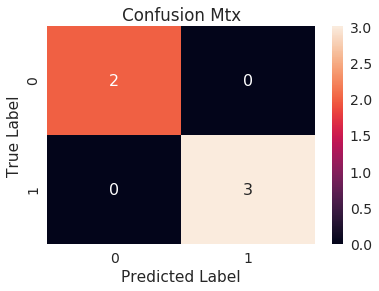

In [127]:
#Random forest classifier model
rando_forest = RandomForestClassifier(numTrees=10)
rando_forest_model = rando_forest.fit(train)
rando_forest_preds = rando_forest_model.transform(validation)
custom_evaluation(rando_forest_preds, 'Random Forest')

Gradient Boosted Trees -> PR AUC: 1.0
Gradient Boosted Trees
 | precision = 1.0
 | recall = 1.0
 | F1-Score = 1.0


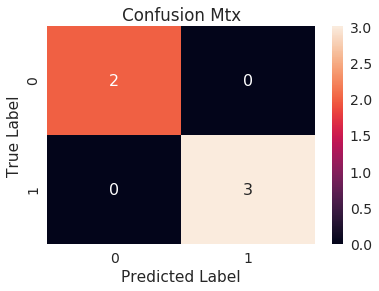

In [128]:
#Gradient boosted trees (ie ada boost)
gbtrees = GBTClassifier(maxIter=10)
gbtree_model = gbtrees.fit(train)
gbtree_preds = gbtree_model.transform(validation)
custom_evaluation(gbtree_preds, 'Gradient Boosted Trees')

Support Vector Machine -> PR AUC: 1.0
Support Vector Machine
 | precision = 1.0
 | recall = 1.0
 | F1-Score = 1.0


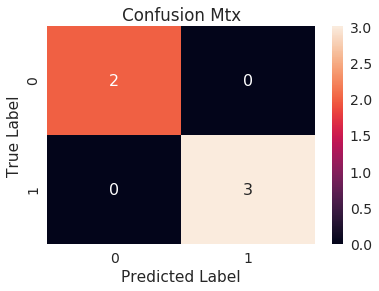

In [129]:
#SVM
svm = LinearSVC(maxIter=10, regParam=0.1)
svm_model=svm.fit(train)
svm_preds=svm_model.transform(validation)
custom_evaluation(svm_preds, 'Support Vector Machine')

Logistic Regression -> PR AUC: 1.0
Logistic Regression
 | precision = 0.4
 | recall = 0.4
 | F1-Score = 0.4


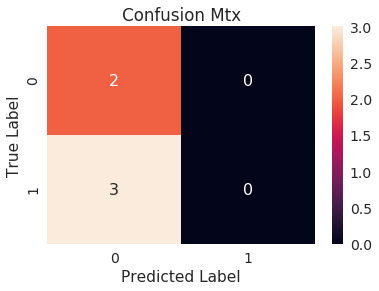

In [130]:
#Logistic regression model
logReg = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
lrModel = logReg.fit(train)
lr_preds = lrModel.transform(validation)
custom_evaluation(lr_preds, 'Logistic Regression')

In [131]:
#Visual check for predictions
for x in [svm_preds, lr_preds, gbtree_preds, rando_forest_preds]:
    x.select('features', 'rawPrediction', 'prediction', 'label').show()

+--------------------+--------------------+----------+-----+
|            features|       rawPrediction|prediction|label|
+--------------------+--------------------+----------+-----+
|[0.0,1.0,0.315068...|[-0.9771510091968...|       1.0|  1.0|
|[0.33333333333333...|[-1.4067021398948...|       1.0|  1.0|
|[0.0,1.0,0.054794...|[-1.6442177020221...|       1.0|  1.0|
|[0.33333333333333...|[1.45283571752417...|       0.0|  0.0|
|[0.0,0.0,0.082191...|[1.13995243762261...|       0.0|  0.0|
+--------------------+--------------------+----------+-----+

+--------------------+--------------------+----------+-----+
|            features|       rawPrediction|prediction|label|
+--------------------+--------------------+----------+-----+
|[0.0,1.0,0.315068...|[0.29836075425595...|       0.0|  1.0|
|[0.33333333333333...|[0.29836075425595...|       0.0|  1.0|
|[0.0,1.0,0.054794...|[0.29836075425595...|       0.0|  1.0|
|[0.33333333333333...|[1.86307471057955...|       0.0|  0.0|
|[0.0,0.0,0.082191...|[

In [132]:
# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", metricName = 'areaUnderPR')
for x in [svm_preds, lr_preds, gbtree_preds, rando_forest_preds]:
    print(x,evaluator.evaluate(x))

DataFrame[userId: string, downgraded: bigint, cancelled: bigint, visited_cancel: bigint, visited_downgrade: bigint, dailyHelpVisits: double, dailyErrors: double, free: int, paid: int, avgThumbsUp: double, avgThumbsDown: double, numFriends: bigint, avgSongsTillHome: double, avgTimeSkipped: double, skipRate: double, label: double, feature_vec: vector, features: vector, rawPrediction: vector, prediction: double] 1.0
DataFrame[userId: string, downgraded: bigint, cancelled: bigint, visited_cancel: bigint, visited_downgrade: bigint, dailyHelpVisits: double, dailyErrors: double, free: int, paid: int, avgThumbsUp: double, avgThumbsDown: double, numFriends: bigint, avgSongsTillHome: double, avgTimeSkipped: double, skipRate: double, label: double, feature_vec: vector, features: vector, rawPrediction: vector, probability: vector, prediction: double] 1.0
DataFrame[userId: string, downgraded: bigint, cancelled: bigint, visited_cancel: bigint, visited_downgrade: bigint, dailyHelpVisits: double, dail

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.